# Weekly Report 21/11/2016

## Jupyter

This report looks very different from the reports in the previous weeks.

Following Simon's and John's suggestion I stopped running analyses as a bunch of python & bash scripts (although one bash script still remains) and refactored most of the code into jupyter notebooks. Because jupyter supports markdown, the report itself is also a part of the notebook.

This proved to be more challenging than I thought, but I believe it was a worthwhile effort.

The main difficulty is that various bits of analysis are written in python and R (and a few remaining lines of bash) and I needed a solution, which could run the right bit of analysis in the right time. While jupyter supports both R and python, it doesn't support mixing them within one notebook. A workaround I eventually managed to figure out is to split the analysis into multiple notbooks and execute all "auxiliary" notebooks from a "master" notebook using some internal functionality of jupyter. This may not be ideal, but it's the best I could do.

Other difficulties remain: 

1. The report may be hard to read, because the computation of the results, their description & their presentation are interleaved. 
2. The report will become longer every week. The most relevant bits will live at the end of the notebook.
3. Many small things are not working: installing R packages is awkward, some R functions are not supported, spellcheck doesn't work, R kernel sometimes dies for no reason, code boxes overflow in the pdf version, double quotation marks are broken in the pdf version, etc.

As to the benefits of this approach:

1. Jupyter is interactive, which means I don't have to wait 10 seconds on each execution of each script. This really has big impact on productivity, as each script is executed hundreds of times, i.e. on every small modification of the codebase. Using my workaround we do not lose the batch-processing capability.
2. Jupyter supports markdown cells, which means I can document what I'm doing as I go.
3. Jupyter supports inline plots. This is another productivity gain, as writing pngs to disk (and correctly naming them!) and then manually attaching them to latex files was slow & error-prone.
4. It becomes easier to achieve the solution reached by Simon's former student: each compilation of dissertation leads to a full re-run of all notebooks, which in turn leads to fully reproducible research (how did this student deal with software dependencies though? A docker container could be a way...).

## Are ISEs a failure of normalisation?

I'm trying to validate Darren's concern raised last week (more details at the end of this notebook).

## Ordering genes by their significance

I order genes by their significance using ordinary linear regression and Benjamini–Hochberg procedure in python. I try the same using limma's regression in R, but there are still some problems remaining (more details in notebook analyseLimma.ipynb).

## Disease-Specific effects in python

I compute Disease Specific Effects (DSEs) in python and try to reproduce Wilf's results (more details at the end of this notebook).


# Analysis of microarry data from patients with myotonic dystrophy.

# Pre-process & Normalise data

In [1]:
# First check if all CEL files are present. We expect data from 35 patients

import os, os.path

CEL_LOCATION = os.path.join("CELfiles", "blood")

CELFILES = os.listdir(CEL_LOCATION)
CELFILES = [file for file in CELFILES if file[-4:] == ".CEL"]

assert(len(CELFILES) == 35)

In [2]:
# Carry out RMA normalisation on all CEL files. Write output to corefile. This step takes a few minutes (unless corefile already exists).

import utils
corefile =  os.path.join(CEL_LOCATION, "core")
try:
    with open(corefile, "rb") as f:
        print("corefile exists")
except FileNotFoundError:
    utils.executeNotebook("normalise.ipynb", CEL_LOCATION)
    print("corefile created")

corefile created


In [3]:
# Retrieve HUAX IDs from CEL files

import sys
import re
import json

def processCELFile(basePath, lastPath):
    relPath = os.path.join(basePath, lastPath)
    result = ""
    with open(relPath, "rb") as f:
        lines = f.readlines()
        for i, line in enumerate(lines[0:20]):
            try:
                result = re.search(b"(\d)*HUEX1A11", line).group()
                
            except AttributeError:
                pass
    return result.decode("utf-8")
CELTOHUAX = {}
for celfile in CELFILES:
    CELTOHUAX[celfile] = str(processCELFile(CEL_LOCATION, celfile))

In [4]:
# Swap IDs from CEL to HUEX
filename = os.path.join(CEL_LOCATION, "core")
with open(filename, "r") as f:
    lines = f.readlines()
    swapped = [CELTOHUAX[line] for line in lines[0].rstrip().split("\t")[1:]]

swappedLine = "IDs\t" + "\t".join(swapped)
with open("normalisedFirstLine", "w") as f:
    f.write(swappedLine)
    f.write("\n")

In [5]:
# Finish off the job using a bash script and a complicated python script, which pulls data from all over the place.

import subprocess
completed = subprocess.run("./analyseBlood.sh", stdout=subprocess.PIPE, stderr=subprocess.PIPE)

completed.check_returncode()

#print("stdout")
#print(completed.stdout.decode("utf-8"))
#print("stderr")
#print(completed.stderr.decode("utf-8"))

## pre-processing & normalisation finished. File `cleaned` written to hard drive in current working directory.

# Analyse the data using Numpy

1. Fit Modal allele length to each gene using ordinary linear regression.
2. Expose the primary dataset as `CLEANED` residuals as `RESIDUALS`, Existence of Individuals Specific Effects as `RESIDUALS_PVALUES`, and Individual Specific Effects as `ISEs` and Modal Allele length as `MODAL_ALLELE`.

In [6]:
# Load file `cleaned` back into python

import numpy as np
import scipy.stats

filename = "cleaned"
with open(filename) as f:
    rowID = None
    skipCount = 0
    while rowID != "Affymetrix":
        line = f.readline().rstrip().split()
        skipCount += 1
        rowID = line[0]
        if rowID == "IDs":
            columns = range(len(line))[1:]
            ids = line[1:]
        if rowID == "ModalAllele":
            MODAL_ALLELE = [int(i) for i in line[1:]]

with open(filename) as f:
    CLEANED =  np.loadtxt(f, delimiter="\t", skiprows=skipCount, usecols=columns)

def numpyAnalysis(CLEANED):
    RESIDUALS = np.zeros_like(CLEANED)

    rowNo, columnNo = CLEANED.shape

    GENE_PVALUES = []

    for i in range(rowNo):
        slope, intercept, r_value, p_value, _ = scipy.stats.linregress(MODAL_ALLELE, list(CLEANED[i]))
        GENE_PVALUES.append(p_value)
        expected = [slope * value + intercept for value in MODAL_ALLELE]
        residuals = [actual - expected for actual, expected in zip(CLEANED[i], expected)]
        for j, residual in enumerate(residuals):
            RESIDUALS[i][j] = residual

    RESIDUALS_PVALUES = []
    ISEs = []
    for i in range(columnNo):
        p_value = scipy.stats.ttest_1samp(RESIDUALS[..., i], 0)[1]
        ISEs.append(sum(RESIDUALS[..., i])/rowNo)
        RESIDUALS_PVALUES.append(p_value)
    return (CLEANED, RESIDUALS, RESIDUALS_PVALUES, MODAL_ALLELE, ISEs, GENE_PVALUES)

CLEANED, RESIDUALS, RESIDUALS_PVALUES, MODAL_ALLELE, ISEs, GENE_PVALUES = numpyAnalysis(CLEANED)

_ = CLEANED # RMA normalised Affymetrix data
_ = RESIDUALS # Residuals computed from MODAL_ALLELE
_ = RESIDUALS_PVALUES # Existence of Individual Specific Effects (ISEs).
_ = MODAL_ALLELE # Modal allele length
_ = ISEs # Individual Specific Effects.
_ = GENE_PVALUES # P-value for each gene

## Analysing primary dataset with `numpy` finished. Appropriate variables exposed.

## Boxplot of residuals

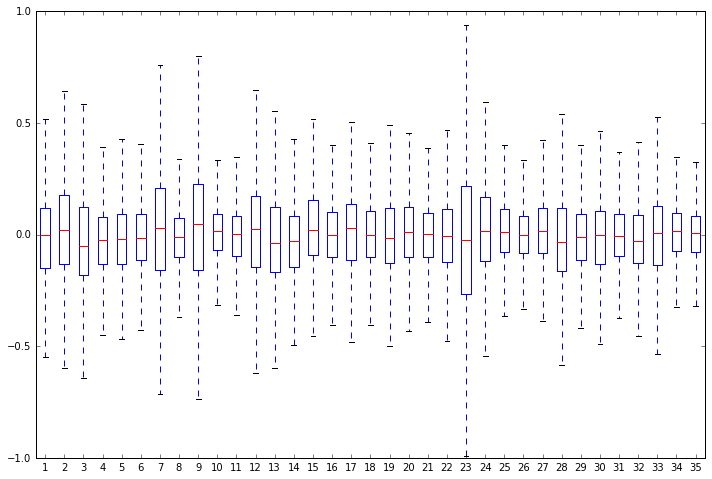

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

data_to_plot = [[RESIDUALS[:, i]] for i in range(CLEANED.shape[1])]
fig = plt.figure()
plt.boxplot(data_to_plot, showfliers=False)
plt.show()

## y-logged graph of p-values

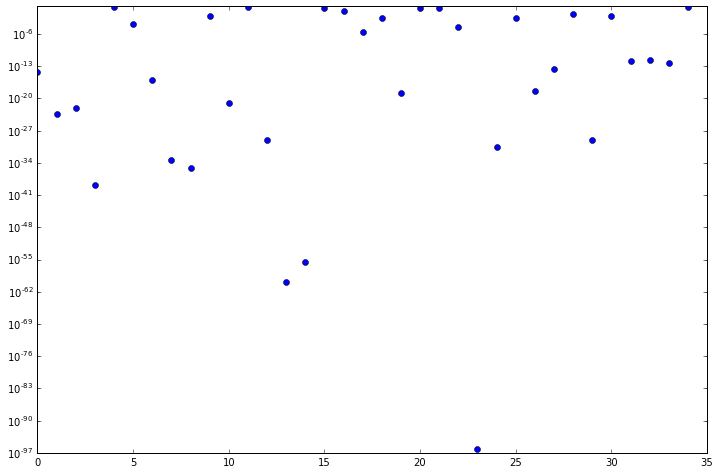

In [8]:
import math
fig = plt.figure()
plt.semilogy(range(len(RESIDUALS_PVALUES)), RESIDUALS_PVALUES, marker="o", lineWidth=0)
plt.show()

# Are ISEs a failure of normalisation?

By failure of normalisation, we mean that either:

1. ISEs are an artifact of slight differences in individual's mean gene expression.
2. ISEs are an artifact of slight differences in variance of individual's gene expression.

There are a few ways to check possibility 1:

1. Are p-values testing for ISEs positively correlated with mean gene expression?
2. Do ISEs disappear when we mean-adjust all the genes?

## First compute mean Gene Expression Level (GEL) for each individual.

In [9]:
CLEANED.shape[1] # this is the number of individuals in the study.
CLEANED.shape[0] # this is the number of genes.

MEAN_GEL = [] # mean gene expression levels, per individual.

for i in range(CLEANED.shape[1]):
    MEAN_GEL.append(sum(CLEANED[...,i])/CLEANED.shape[0])
MEAN_MEAN_GEL = sum(MEAN_GEL)/len(MEAN_GEL)

## Then plot mean expression levels against logged ISEs p-values
1. green line is y=0.05
2. red line is x=`MEAN_MEAN_GEL`, where `MEAN_MEAN_GEL` is a mean expression level of all genes from all individuals.

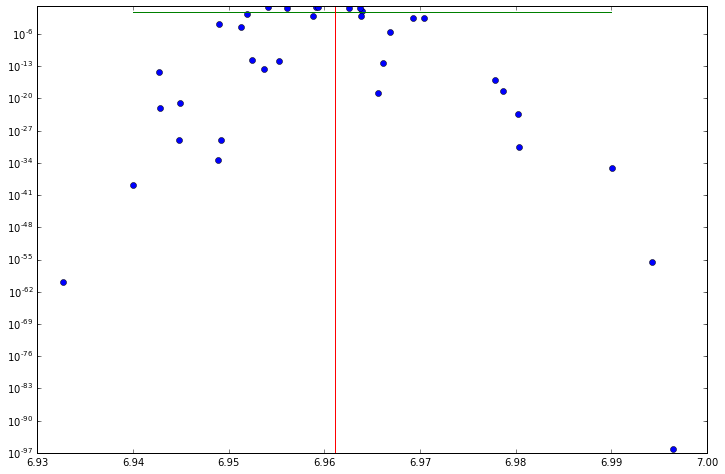

In [10]:
fig = plt.figure()
plt.semilogy(MEAN_GEL, RESIDUALS_PVALUES, marker="o", lineWidth=0)
plt.semilogy([6.94, 6.99], [0.05, 0.05])
plt.semilogy([MEAN_MEAN_GEL]*2, [pow(10, -97), 1])
plt.show()

## And plot mean expression levels against ISEs.

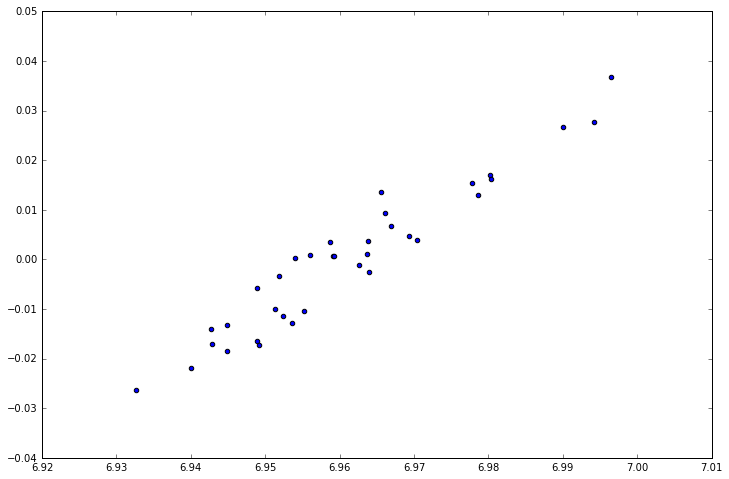

In [11]:
fig = plt.figure()
plt.scatter(MEAN_GEL, ISEs, marker="o")#, lineWidth=0, label="hello"
plt.show()

### These plots suggest that both existence and value of ISEs depends on the mean GEL in each individual. However, a closer look at the p-values plot suggests that this may not be the entire story -- we still end up with some really small p-values (1/300) -- even very close around the mean.

1. green line is y=0.05
2. red line is x=`MEAN_MEAN_GEL`, where `MEAN_MEAN_GEL` is a mean expression level of all genes from all individuals.

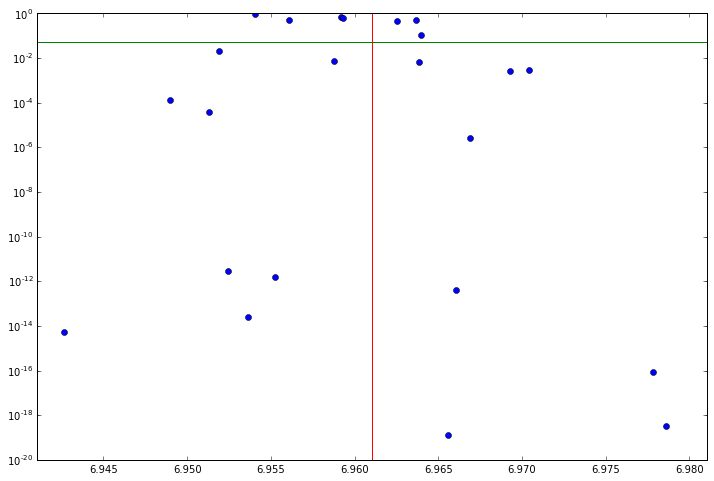

In [12]:
fig = plt.figure()
xrange = [MEAN_MEAN_GEL - 0.02, MEAN_MEAN_GEL + 0.02]
yrange = [10**(-20), 1]
plt.semilogy(MEAN_GEL, RESIDUALS_PVALUES, marker="o", lineWidth=0)
plt.semilogy(xrange, [0.05, 0.05])
plt.semilogy([MEAN_MEAN_GEL]*2, yrange)
plt.xlim(xrange)
plt.ylim(yrange)
plt.show()

# Gene significance using Benjamini-Hochberg

## first, load transcription cluster ids from `cleaned`

In [13]:
filename = "cleaned"

T_CLUSTER_IDS = []

MAP_T_CLUSTER_INDEX = {}

read = False
with open("cleaned") as f:
    lines = f.readlines()
    i = 0
    for line in lines:
        line = line.rstrip().split("\t")
        if read:
            T_CLUSTER_IDS.append(line[0])
            MAP_T_CLUSTER_INDEX[line[0]] = i
            i += 1
        if line:
            if line[0] == "Affymetrix":
                read = True

assert(len(T_CLUSTER_IDS) == len(GENE_PVALUES))

## Then sort genes in ascending order of GENE_PVALUES

In [14]:
benjhoch = list(zip(GENE_PVALUES, T_CLUSTER_IDS))
benjhoch.sort()

## Then multiply each gene by m/k, where m is the number of hypotheses tested and k = 1, ...,  m

In [15]:
m = len(benjhoch)
k = range(1, len(benjhoch) + 1)
sortedGenes = [((a[0] * m)/(b), a[1]) for a, b in zip(benjhoch, k)]

# unit test for least significat gene
test1 = min(GENE_PVALUES) * m
test2 = sortedGenes[0][0]
assert(abs(test1 - test2) < pow(10, -10))

# unit test for most significat gene
test1 = max(GENE_PVALUES)
test2 = sortedGenes[-1][0]
assert(abs(test1 - test2) < pow(10, -10))

# unit test for least significant gene in a different way

geneID = sortedGenes[0][1]
uncorrected = GENE_PVALUES[MAP_T_CLUSTER_INDEX[geneID]]
assert(uncorrected * m == min(GENE_PVALUES) * m)

# Then answer the question: for any given $\alpha$, where $\alpha$ is the cutoff between $[0, 1]$, how many genes can we detect as significant?

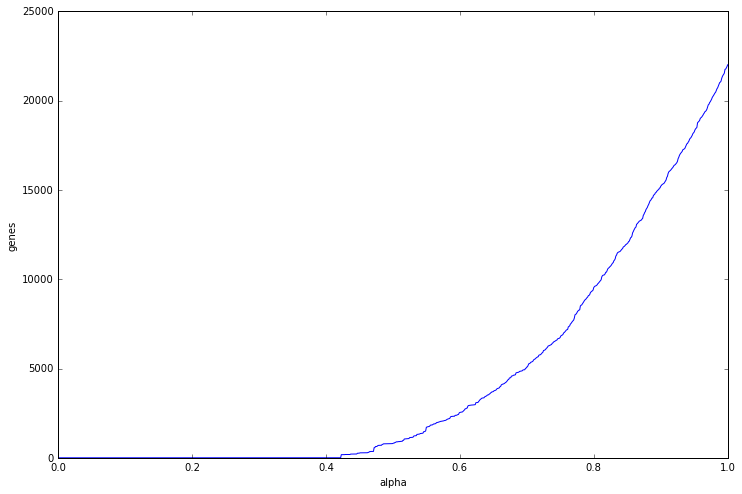

In [16]:
movingMin = sortedGenes[0][0]

alphas = [0.001 * i for i in range(1001)]

def genesForAlpha(sortedGenes, alpha):
    lastGene = -1
    for i, geneTuple in enumerate(sortedGenes):
        significance, geneID = geneTuple
        if significance < alpha:
            lastGene = i
    if lastGene >= 0:
        return sortedGenes[0:lastGene + 1]
    else:
        return []

geneCount = [len(genesForAlpha(sortedGenes, alpha)) for alpha in alphas]

plt.plot(alphas, geneCount)
plt.xlabel("alpha")
plt.ylabel("genes")
plt.show()

## zoom into into the "few genes" region

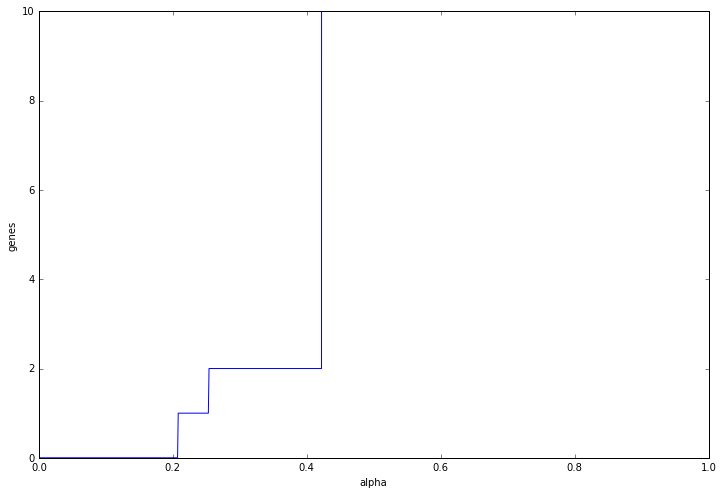

In [17]:
plt.plot(alphas, geneCount)
plt.ylim(0, 10)
plt.xlabel("alpha")
plt.ylabel("genes")
plt.show()

## Or give a list of transcription clusters with FDR of 40%

In [18]:
genesForAlpha(sortedGenes, 0.40)

[(0.20767253459146329, '3139557'), (0.25361044891295487, '2968452')]

## Or give a list of transcription clusters with FDR of 50%

In [19]:
alpha = 0.50
sigGenes = genesForAlpha(sortedGenes, alpha)
noSigGenes = len(sigGenes)
print("number of genes at alpha", alpha, "is", noSigGenes)
print("the 2 genes around the boundary have significance", sortedGenes[noSigGenes - 1][0], sortedGenes[noSigGenes][0])
print("the first 5 genes are")
sigGenes[:5]

number of genes at alpha 0.5 is 803
the 2 genes around the boundary have significance 0.499681381299 0.502117215837
the first 5 genes are


[(0.20767253459146329, '3139557'),
 (0.25361044891295487, '2968452'),
 (0.4670672574672507, '2358393'),
 (0.54626219382433827, '2620894'),
 (0.6875488140324012, '2968373')]

This is strange. Such a sudden raise in detected genes is quite surprising (2 genes vs 803, FDR of 40% vs FDR of 50%). I hope that reviewing the proof of Benjamini-Hochberg for my literature review is going to help me understand why this is allowed to happen (Unless this is a bug in my program, probability is playing around with my intuition).

# Disease Specific Effects

## Let us partition the genes at FDR of 50% into 2 groups randomly. Let us compute the DSE of one group, apply it to the other group and check if it helps improve significance.


In [20]:
import random
random.shuffle(sigGenes)
genesA = sigGenes[:noSigGenes//2]
genesB = sigGenes[noSigGenes//2:]

# unit test our map
test1 = CLEANED[MAP_T_CLUSTER_INDEX["2315554"]][0]
test2 = 7.54562452199732
assert(abs(test1 - test2) <= pow(10, -10))

# compute Disease Specific effects
DSE = [0]*CLEANED.shape[1]
relevantGenesAIndex = [MAP_T_CLUSTER_INDEX[t_cluster_id] for _, t_cluster_id in genesA]
relevantGenesBIndex = [MAP_T_CLUSTER_INDEX[t_cluster_id] for _, t_cluster_id in genesB]

for i in range(CLEANED.shape[1]):
    relevantResiduals = [RESIDUALS[j,i] for j in relevantGenesAIndex]
    DSE[i] = sum(relevantResiduals)/len(relevantResiduals)

# copy CLEANED into another array
DSE_ADJUSTED = np.copy(CLEANED)

# adjust genes in set B with DSEs computed from genes in set A
for i in relevantGenesBIndex:
    for j in range(CLEANED.shape[1]):
        DSE_ADJUSTED[i][j] -= DSE[j]


## Now, let's repeat the numpy analysis using `DSE_ADJUSTED`

In [21]:
CLEANED_B, RESIDUALS_B, RESIDUALS_PVALUES_B, MODAL_ALLELE_B, ISEs_B, GENE_PVALUES_B = numpyAnalysis(DSE_ADJUSTED)

## Now, let's count in how many cases the p-values have improved

In [22]:
#print(relevantGenesBIndex)

previousPValues = [GENE_PVALUES[i] for i in relevantGenesBIndex]
currentPValues = [GENE_PVALUES_B[i] for i in relevantGenesBIndex]
countSmaller = 0
for i, _ in enumerate(relevantGenesBIndex):
    if (currentPValues[i] < previousPValues[i]):
        #print(currentPValues[i], previousPValues[i])
        countSmaller += 1
print("P-values have improved in", countSmaller/len(currentPValues), "fraction of cases")
print("P-values have worsened in", 1 - countSmaller/len(currentPValues), "fraction of cases")

P-values have improved in 0.4228855721393035 fraction of cases
P-values have worsened in 0.5771144278606966 fraction of cases


The values printed in the previous cells are random and determined by a particular random seed, but from running it a couple of times I've seen both fractions to be rather similar.

# Weekly Report 08/12/2016

## Biopython

I have written a parser, which allows one to access raw probe data from the Affymetrix CEL files version 4 (which is what we're working with). My work gained interest of a large open-source bioinformatics package called Biopython. I discussed contributing this parser to Biopython with the maintainer of this package, Peter Cock.

At the time of this writing, the code I've written underwent very scrupulous review, but after 8 revisions it looks like it will get merged into the next version of Biopython (whenever that's released).

There are a number benefits to this of both political and scientific value.

Political:

- If we discover anything interesting we would find it much easier to distribute it as part of biopython (as opposed to distributing it ourselves).
- We're doing a good service to the community.

Scientific:

We can now easily detect/fix some of the issue with our data:

- Aren't all of our probes oversaturated/ undersaturated?
- How do we know if a probe is broken (or there is a scratch on the microarray)?
- RMA doesn't normalise means, can we write our own better-RMA?

What the parser gives us is ~5.5 million of triplets of
the form:

(double, double, integer)

The last number is the number of pixels per probe from which an
intensity measurement was taken. This is always 9.

The first number is the average intensity of these pixels.

The middle number is the standard deviation.

The following are the first few triplets:

    (7326.0, 875.0999755859375,  9)
    (162.0,  34.099998474121094, 9)
    (6933.0, 1001.0,             9)
    (224.0,  36.400001525878906, 9)
    (54.0,   6.0,                9)
    (247.0,  23.5,               9)
    (210.0,  18.299999237060547, 9)

## Literature Review

I've started writing the literature review (the deadline is 16th of January). That's attached. 

## Wilf's results

I've re-read Wilf's report and tried to see which bits of analysis I'm missing.

## Comparing my results with John's